## Importing Important Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Loading Dataset

In [3]:
xls=pd.ExcelFile("online_retail_II.xlsx")
df_2009_2010 = pd.read_excel(xls, sheet_name="Year 2009-2010", usecols=["Invoice", "Quantity", "InvoiceDate", "Price", "Customer ID"])
df_2010_2011 = pd.read_excel(xls, sheet_name="Year 2010-2011", usecols=["Invoice", "Quantity", "InvoiceDate", "Price", "Customer ID"])

In [37]:
#combine both year's data
df=pd.concat([df_2009_2010, df_2010_2011],ignore_index=True)
df.head()

,Invoice,Quantity,InvoiceDate,Price,Customer ID
0,489434,12,2009-12-01 07:45:00,6.95,13085.0
1,489434,12,2009-12-01 07:45:00,6.75,13085.0
2,489434,12,2009-12-01 07:45:00,6.75,13085.0
3,489434,48,2009-12-01 07:45:00,2.10,13085.0
4,489434,24,2009-12-01 07:45:00,1.25,13085.0


### Data Preprocessing

In [14]:
df.dropna(subset=["Customer ID"],inplace=True)

df["Customer ID"]=df["Customer ID"].astype(int)

df=df[df["Quantity"]>0]

df["TotalPrice"]=df["Quantity"] * df["Price"]

df["InvoiceDate"]= pd.to_datetime(df["InvoiceDate"])

latest_date=df["InvoiceDate"].max()


In [15]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,805620.000000,805620,805620.000000,805620.000000,805620.000000
mean,13.307665,2011-01-02 10:26:35.704326144,3.206279,15331.856250,22.024564
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.000000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000,4.950000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000,11.850000
75%,12.000000,2011-07-28 13:28:00,3.750000,16805.000000,19.500000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000,168469.600000
std,144.306739,NaN,29.197901,1696.768395,224.032150


## RFM Analysis (Recency, Frequencyand Monetary value)

In [17]:
rfm=df.groupby("Customer ID").agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency (days since last purchase)
    'Invoice': 'nunique',  # Frequency (number of transactions)
    'TotalPrice': 'sum'  # Monetary (total spending)
})

rfm.rename(columns={"InvoiceDate": "Recency", "Invoice" :"Frequency", "TotalPrice" : "Monetary"}, inplace=True)

In [18]:
rfm_log=np.log1p(rfm)   #to normalize skewed data

scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_log)

## K-Means Clustering

In [20]:
inertia=[]
k_values=range(2,11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

### Elbow Method

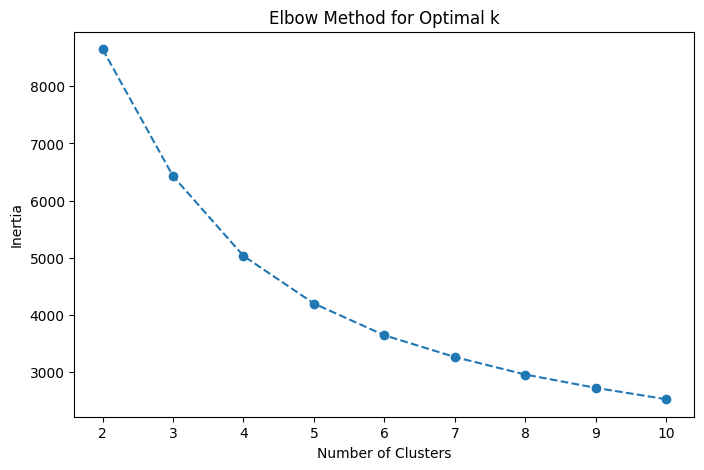

In [21]:
# Plot Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [22]:
# Apply K-Means clustering with optimal k (choosing 4 based on elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

## Data Visualization

In [31]:
cluster_labels = {
    0: 'Moderate Value Customers',
    1: 'Low Value Customers',
    2: 'High Value Customers',
    3: 'Recent Buyers'
}
rfm['Cluster Label'] = rfm['Cluster'].map(cluster_labels)

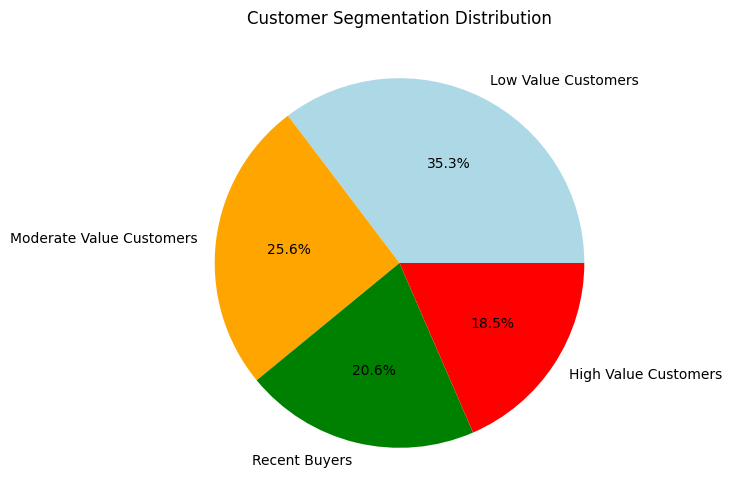

In [33]:
plt.figure(figsize=(6,6))
rfm['Cluster Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'orange', 'green', 'red'])
plt.title('Customer Segmentation Distribution')
plt.ylabel('')
plt.show()

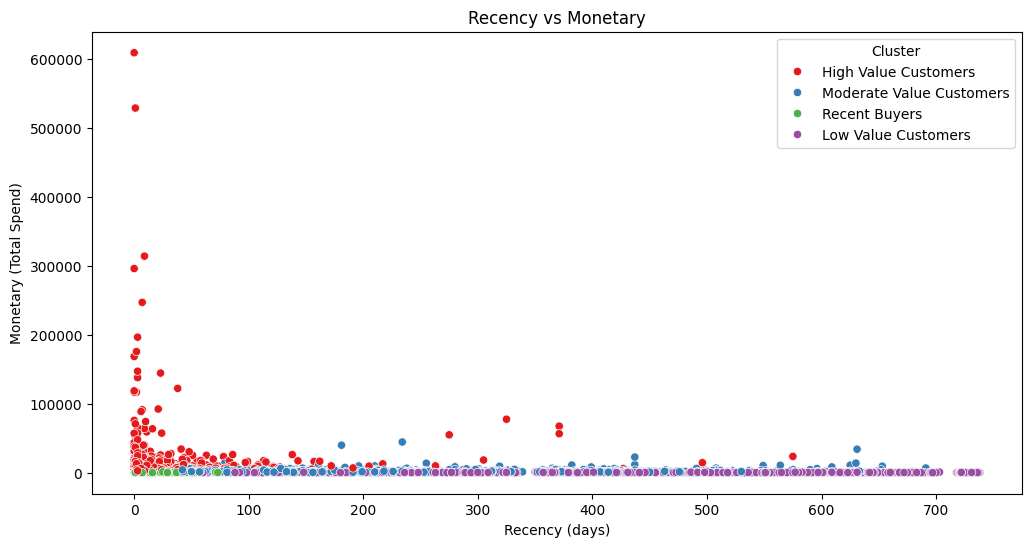

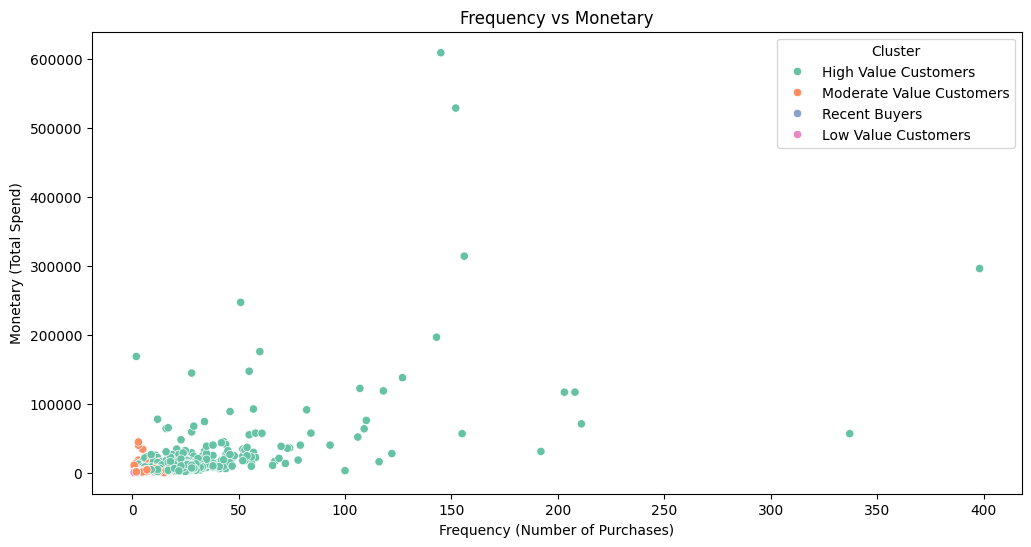

In [34]:
# Cluster Scatter Plots
plt.figure(figsize=(12,6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster Label'], palette='Set1')
plt.title('Recency vs Monetary')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x=rfm['Frequency'], y=rfm['Monetary'], hue=rfm['Cluster Label'], palette='Set2')
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

## Cluster Summary

In [44]:
rfm_summary = rfm.groupby(['Cluster', 'Cluster Label']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)
print('Cluster Summary:')
rfm_summary.head()

Cluster Summary:


,,Recency,Frequency,Monetary
Cluster,Cluster Label,,,
0,Moderate Value Customers,204.90,5.48,2177.47
1,Low Value Customers,390.83,1.42,348.54
2,High Value Customers,24.07,20.34,11687.09
3,Recent Buyers,26.60,3.02,854.70


# Conclusion
### This customer segmentation helps businesses:
## ✔ Identify key customers
## ✔ Improve customer retention
## ✔ Create personalized marketing strategies 🚀

# This is how we analyze and cluster customers using RFM and K-Means!